# Purpose
get a normalization factor.

## setup modules

In [1]:
import glob
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import scipy.interpolate as interp
import os
from typing import Tuple, Union, Dict

%matplotlib inline

In [2]:
def print_h5_tree(val, pre=''):
    if isinstance(val, h5py._hl.files.File):
        print(val.filename)

    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if isinstance(val, h5py._hl.group.Group):
                print(pre + '└── ' + key)
                print_h5_tree(val, pre+'    ')
            else:
                print(pre + '└── ' + key)
        else:
            if isinstance(val, h5py._hl.group.Group):
                print(pre + '├── ' + key)
                print_h5_tree(val, pre+'│   ')
            else:
                print(pre + '├── ' + key)

## list up the outputs

In [3]:
srcdir = "../output_data/01_simulation/"
srclist = sorted(glob.glob(os.path.join(srcdir, "*.h5")))

In [4]:
with h5py.File(srclist[0], "r") as tree:
    print_h5_tree(tree)

../output_data/01_simulation/fourier_modulus_R10.40A.h5
├── input_parameters
│   ├── incident_xray_beam
│   │   └── wavelength
│   ├── momentum_space
│   │   ├── momentum_max
│   │   └── momentum_step
│   └── target
│       ├── atom_number
│       ├── crystal_characteristic_length
│       ├── crystal_shape
│       ├── crystal_structure
│       ├── miller_index
│       └── unit_cell_length
└── outputs
    ├── incident_xray_beam
    │   └── wavenumber
    ├── main_outputs
    │   ├── coordinates_of_atoms
    │   └── fourier_modulus
    ├── momentum_space
    │   ├── momentum_x
    │   ├── momentum_y
    │   └── momentum_z
    └── target
        └── euler_angle


## get the Fourier modulus of the target crystal with the maximum radius

In [5]:
radii = []
for fpath in srclist:
    with h5py.File(fpath, "r") as tree:
        radii.append(tree['input_parameters']['target']['crystal_characteristic_length'][()])

radii = np.array(radii)

In [6]:
radii.max(), np.where(radii == radii.max())[0][0]

(112.0, 2)

The maximum radius is 112.00 angstroms.

In [7]:
def get_fourier_modulus(fpath: str) -> np.ndarray:
    dst = None
    with h5py.File(fpath, "r") as tree:
        dst = tree['outputs']['main_outputs']['fourier_modulus'][()]
    return dst

In [8]:
ind_radii_max = np.where(radii == radii.max())[0][0]

F = get_fourier_modulus(srclist[ind_radii_max])
I_radii_max = np.abs(F)**2

pos = np.where(I_radii_max == I_radii_max.max())

pos

(array([250]), array([250]))

## get a position of a Bragg spot

In [9]:
def get_qrange(fpath: str) -> Tuple[Union[Dict[str, Union[Tuple[float], float]], float]]:
    qranges = {
        'x': None,  # (min, max)
        'y': None,  # (min, max)
    }
    dqs = {
        'x': None,
        'y': None,
    }
    q_spot_expected = None
    with h5py.File(fpath, "r") as tree:
        qranges['x'] = (
            tree['outputs']['momentum_space']['momentum_x'][()].min(),
            tree['outputs']['momentum_space']['momentum_x'][()].max()
        )
        qranges['y'] = (
            tree['outputs']['momentum_space']['momentum_y'][()].min(),
            tree['outputs']['momentum_space']['momentum_y'][()].max()
        ) 

        dqs['x'] = np.diff(sorted(np.unique(tree['outputs']['momentum_space']['momentum_x'][()])))[0]
        dqs['y'] = np.diff(sorted(np.unique(tree['outputs']['momentum_space']['momentum_y'][()])))[0]

        q_spot_expected = 2. * np.pi / tree['input_parameters']['target']['unit_cell_length'][()] * \
            np.linalg.norm(tree['input_parameters']['target']['miller_index'][()])
    
    return qranges, dqs, q_spot_expected

In [10]:
qranges, dqs, q_spot_expected = get_qrange(srclist[ind_radii_max])

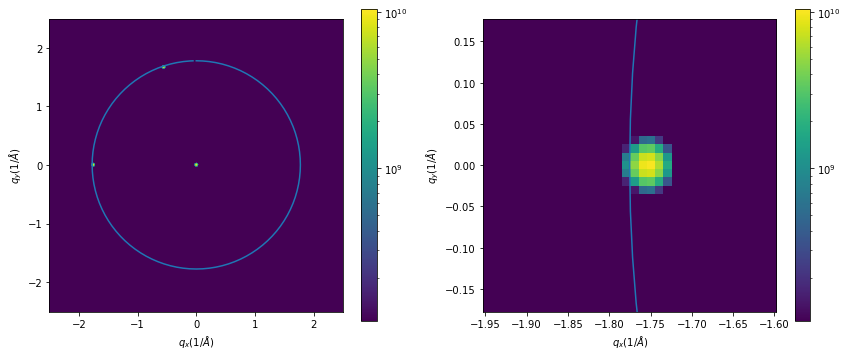

In [11]:
extent = [
    qranges['x'][0] - dqs['x'] / 2.0, qranges['x'][1] + dqs['x'] / 2.0,
    qranges['y'][0] - dqs['y'] / 2.0, qranges['y'][1] + dqs['y'] / 2.0
]  # (left, right, bottom, top)

# show the modulus
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(
    I_radii_max, origin='lower', extent=extent,
    norm=LogNorm(vmin=I_radii_max.max() / 1e2, vmax=I_radii_max.max())
)

# plot a circle with a radius of $2\pi / d(111)$
theta = np.arange(0., 2.*np.pi, np.pi/100)
plt.plot(q_spot_expected * np.sin(theta), q_spot_expected * np.cos(theta), '-')

plt.xlabel('$q_x (1/\AA$)')
plt.ylabel('$q_y (1/\AA$)')
plt.colorbar()

# zoom-in
plt.subplot(122)
plt.imshow(
    I_radii_max, origin='lower', extent=extent,
    norm=LogNorm(vmin=I_radii_max.max() / 1e2, vmax=I_radii_max.max())
)

# plot a circle with a radius of $2\pi / d(111)$
theta = np.arange(0., 2.*np.pi, np.pi/100)
plt.plot(q_spot_expected * np.sin(theta), q_spot_expected * np.cos(theta), '-')

plt.xlabel('$q_x (1/\AA$)')
plt.ylabel('$q_y (1/\AA$)')

width = q_spot_expected * 0.1
plt.xlim(-q_spot_expected - width, -q_spot_expected + width)
plt.ylim(-width, width)
plt.colorbar()

plt.tight_layout()

A Bragg spot was observed at around $(q_x, q_y) = (-q_{expect}, 0.0)$, where $q_{expect}$ is the momentum transfer calculated from the Miller index.

In [12]:
def get_spot_positions(
    fpath: str, intensity_map: np.ndarray, pos_expected: Tuple[float],
    width: float, threshold: float = None
) -> Tuple[dict]:
    if not threshold:
        threshold = intensity_map.max() / 1e3
    qranges, dqs, q_spot_expected = get_qrange(fpath)

    pos_spot_ranges = {  # (min, max)
        'x': None,
        'y': None
    }
    pos_spot_peak = {
        'x': None,
        'y': None
    }
    with h5py.File(fpath, "r") as tree:
        qxx_ = tree['outputs']['momentum_space']['momentum_x'][()]
        qyy_ = tree['outputs']['momentum_space']['momentum_y'][()]
        pos_cand_ = np.where(
            (qxx_ >= pos_expected[1] - width)&(qxx_ <= pos_expected[1] + width)&
            (qyy_ >= pos_expected[0] - width)&(qyy_ <= pos_expected[0] + width)&
            (intensity_map >= threshold_I)
        )
        pos_spot_ranges['x'] = (pos_cand_[1].min(), pos_cand_[1].max())
        pos_spot_ranges['y'] = (pos_cand_[0].min(), pos_cand_[0].max())
        I_ = intensity_map[
            pos_spot_ranges['y'][0]:pos_spot_ranges['y'][1]+1,
            pos_spot_ranges['x'][0]:pos_spot_ranges['x'][1]+1
        ]
        ind_max_in_cand_ = np.where(I_ == I_.max())
        pos_spot_peak['x'] = pos_spot_ranges['x'][0] + ind_max_in_cand_[0][0]
        pos_spot_peak['y'] = pos_spot_ranges['y'][0] + ind_max_in_cand_[0][0]

    pos_spot_qranges = {}
    for key in pos_spot_ranges.keys():
        pos_spot_qranges[key] = qranges[key][0] + np.arange(pos_spot_ranges[key][0], pos_spot_ranges[key][1] + 1) * dqs[key]

    pos_spot_peak_q = {}
    for key in pos_spot_peak.keys():
        pos_spot_peak_q[key] = qranges[key][0] + pos_spot_peak[key] * dqs[key]
    
    return pos_spot_ranges, pos_spot_peak, pos_spot_qranges, pos_spot_peak_q

In [13]:
pos_expected = (0.0, -q_spot_expected)
width = q_spot_expected * 0.1
threshold_I = I_radii_max.max() / 1e3

pos_spot_ranges, pos_spot_peak, pos_spot_qranges, pos_spot_peak_q = get_spot_positions(
    srclist[ind_radii_max], I_radii_max, pos_expected, width, threshold_I
)

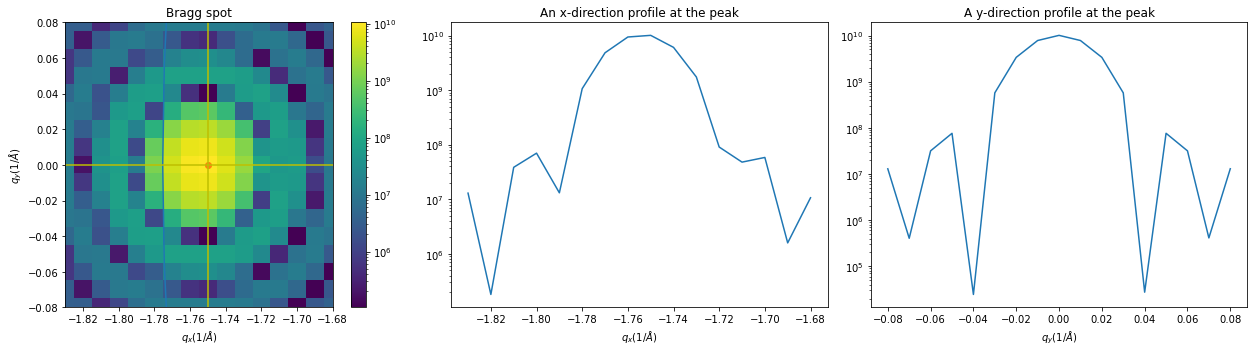

In [14]:
extent = [
    qranges['x'][0] - dqs['x'] / 2.0, qranges['x'][1] + dqs['x'] / 2.0,
    qranges['y'][0] - dqs['y'] / 2.0, qranges['y'][1] + dqs['y'] / 2.0
]  # (left, right, bottom, top)

# show the modulus
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.imshow(
    I_radii_max, origin='lower', extent=extent,
    norm=LogNorm(vmin=threshold_I / 1e2, vmax=I_radii_max.max())
)

# plot a circle with a radius of $2\pi / d(111)$
theta = np.arange(0., 2.*np.pi, np.pi/100)
plt.plot(q_spot_expected * np.sin(theta), q_spot_expected * np.cos(theta), '-')

# plot a peak position and cross lines at the peak
plt.plot(pos_spot_peak_q['x'], pos_spot_peak_q['y'], "o")
plt.hlines(
    pos_spot_peak_q['y'], pos_spot_qranges['x'][0], pos_spot_qranges['x'][-1],
    colors='y'
)
plt.vlines(
    pos_spot_peak_q['x'], pos_spot_qranges['y'][0], pos_spot_qranges['y'][-1],
    colors='y'
)

plt.xlabel('$q_x (1/\AA$)')
plt.ylabel('$q_y (1/\AA$)')
plt.title('Bragg spot')

plt.xlim(pos_spot_qranges['x'][0], pos_spot_qranges['x'][-1])
plt.ylim(pos_spot_qranges['y'][0], pos_spot_qranges['y'][-1])
plt.colorbar()

# plot an x-direction profile at the peak position
plt.subplot(132)
plt.plot(
    pos_spot_qranges['x'],
    I_radii_max[pos_spot_peak['y'], pos_spot_ranges['x'][0]:pos_spot_ranges['x'][1]+1]
)
plt.yscale('log')
plt.xlabel('$q_x (1/\AA$)')
plt.title('An x-direction profile at the peak')

# plot a y-direction profile at the peak position
plt.subplot(133)
plt.plot(
    pos_spot_qranges['y'],
    I_radii_max[pos_spot_ranges['y'][0]:pos_spot_ranges['y'][1]+1, pos_spot_peak['x']]
)
plt.yscale('log')
plt.xlabel('$q_y (1/\AA$)')
plt.title('A y-direction profile at the peak')

plt.tight_layout()

Since the momentum spatial resolution is bad, this time the normalization factor will be calculated as to set $I_{sum} = I_{peak} \times \times {FWHM}_x \times {FWHM}_y$ to 10,000 (photons). Here the unit of FWHM is $\AA^{-1}$. The FWHMs will be estmated with the inner interpolation.

In [15]:
def get_fine_fwhm(
    intensity_map: np.ndarray,
    pos_spot_qranges: dict, pos_spot_peak: dict,
    fine_step: float, find_fwhm_factor: float = 0.05
) -> dict:
    # interpolation functions
    f_interp = {
        'x': interp.interp1d(
            pos_spot_qranges['x'],
            I_radii_max[pos_spot_peak['y'], pos_spot_ranges['x'][0]:pos_spot_ranges['x'][1]+1]
        ),
        'y': interp.interp1d(
            pos_spot_qranges['y'],
            I_radii_max[pos_spot_ranges['y'][0]:pos_spot_ranges['y'][1]+1, pos_spot_peak['x']]
        )
    }

    # interpolation
    fine_step = 0.1  # pixels
    qranges_fine = {}
    for key in pos_spot_qranges.keys():
        qranges_fine[key] = qranges[key][0] + np.arange(
            pos_spot_ranges[key][0], pos_spot_ranges[key][1], fine_step
        ) * dqs[key]

    profiles_fine = {}
    for key in pos_spot_qranges.keys():
        profiles_fine[key] = f_interp[key](qranges_fine[key])

    # find FWHMs
    find_fwhm_factor = 0.05
    fwhms = {}
    for key in pos_spot_qranges.keys():
        ind_lower_ = np.where(
            (qranges_fine[key] <= qranges_fine[key].mean())&
            (profiles_fine[key] >= profiles_fine[key].max()/2 * (1. - find_fwhm_factor))&
            (profiles_fine[key] <= profiles_fine[key].max()/2 * (1. + find_fwhm_factor))
        )[0][0]
        ind_higher_ = np.where(
            (qranges_fine[key] >= qranges_fine[key].mean())&
            (profiles_fine[key] >= profiles_fine[key].max()/2 * (1. - find_fwhm_factor))&
            (profiles_fine[key] <= profiles_fine[key].max()/2 * (1. + find_fwhm_factor))
        )[0][0]
        fwhms[key] = qranges_fine[key][ind_higher_] - qranges_fine[key][ind_lower_]
    return fwhms

In [16]:
fine_step = 0.1  # pixels
find_fwhm_factor = 0.05

fwhms = get_fine_fwhm(
    I_radii_max, pos_spot_qranges, pos_spot_peak,
    fine_step, find_fwhm_factor
)

In [17]:
def calculate_normalization_factor(
    intensity_map: np.ndarray,
    pos_spot_peak: dict,
    fwhms: dict,
    normalized_intensity: float
) -> float:
    I_sum = I_radii_max[pos_spot_peak['y'], pos_spot_peak['x']] * fwhms['x'] * fwhms['y'] / (dqs['x'] * dqs['y'])
    return I_sum_target / I_sum  # photons * $\AA^2$ / (units of I)

In [18]:
I_sum_target = 10000.  # photons

factor = calculate_normalization_factor(
    I_radii_max, pos_spot_peak, fwhms,
    I_sum_target
)

In [19]:
I_spot = I_radii_max[
    pos_spot_ranges['y'][0]:pos_spot_ranges['y'][1]+1,
    pos_spot_ranges['x'][0]:pos_spot_ranges['x'][1]+1
]
I_spot.sum() * factor

10784.96125145771

## save the normalization factor

In [20]:
def add_params(group, key, values):
    if values.get('value'):
        _ = group.create_dataset(key, data=values['value'])
        return group
    group_ = group.create_group(f'{key}')
    for key_, values_ in values.items():
        group_ = add_params(group_, key_, values_)
    return group


def output(dstpath: str, parameters: dict, outputs: dict):
    with h5py.File(dstpath, 'w') as tree:
        # parameters
        tree = add_params(tree, 'input_parameters', parameters)

        # outputs
        tree = add_params(tree, 'outputs', outputs)

In [21]:
parameters = {
    'srcpath': {
        'value': srclist[ind_radii_max],
        'unit': 'none',
        'type': 'str'
    },
    'pos_expected': {
        'value': pos_expected,
        'unit': '1/angstrom',
        'type': 'tuple(float)'
    },
    'width': {
        'value': width,
        'unit': '1/angstrom',
        'type': 'float'
    },
    'threshold': {
        'value': threshold_I,
        'unit': 'arbitrary',
        'type': 'float'
    },
    'fine_step': {
        'value': fine_step,
        'unit': 'pixel',
        'type': 'float'
    },
    'find_fwhm_factor': {
        'value': find_fwhm_factor,
        'unit': 'none',
        'type': 'float'
    },
    'normalized_intensity': {
        'value': I_sum_target,
        'unit': 'photons',
        'type': 'float'
    }
}


In [22]:
outputs = {
    'main_outputs': {
        'normalization_factor': {
            'value': factor,
            'unit': 'photons',
            'type': 'float'
        },
        'fwhm_x': {
            'value': fwhms['x'],
            'unit': '1/angstrom',
            'type': 'tuple(float)'
        },
        'fwhm_y': {
            'value': fwhms['y'],
            'unit': '1/angstrom',
            'type': 'tuple(float)'
        }
    },
    'positions': {
        'pos_spot_range_x': {
            'value': pos_spot_ranges['x'],
            'unit': 'pixel',
            'type': 'tuple(int)'
        },
        'pos_spot_range_y': {
            'value': pos_spot_ranges['y'],
            'unit': 'pixel',
            'type': 'tuple(int)'
        },
        'pos_spot_peak_x': {
            'value': pos_spot_peak['x'],
            'unit': 'pixel',
            'type': 'tuple(int)'
        },
        'pos_spot_peak_y': {
            'value': pos_spot_peak['y'],
            'unit': 'pixel',
            'type': 'tuple(int)'
        }
    }
}

In [23]:
outputdir = '../output_data/02_normalization'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

fname = 'factor.h5'
output(os.path.join(outputdir, fname), parameters, outputs)

## chetk the output

In [24]:
with h5py.File(os.path.join(outputdir, fname), 'r') as tree:
    print_h5_tree(tree)
    print(tree['input_parameters']['srcpath'][()].decode('utf-8'))
    print(tree['outputs']['main_outputs']['normalization_factor'][()])

../output_data/02_normalization/factor.h5
├── input_parameters
│   ├── find_fwhm_factor
│   ├── fine_step
│   ├── normalized_intensity
│   ├── pos_expected
│   ├── srcpath
│   ├── threshold
│   └── width
└── outputs
    ├── main_outputs
    │   ├── fwhm_x
    │   ├── fwhm_y
    │   └── normalization_factor
    └── positions
        ├── pos_spot_peak_x
        ├── pos_spot_peak_y
        ├── pos_spot_range_x
        └── pos_spot_range_y
../output_data/01_simulation/fourier_modulus_R112.00A.h5
9.684539445466332e-08
